## Demo code for Gaussian processes

We'll use this notebook to demonstrate Gaussian processes on some simple data.


In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

## Warmup: 2-dimensional Gaussians

This is the code used to generate some of the first examples in the lecture slides.


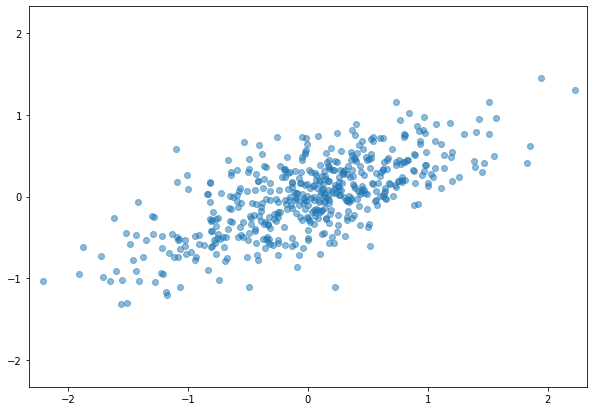

In [2]:
n = 500
X = np.matrix(np.random.normal(loc=0,size=2*n))
X = X.reshape(n, 2)
X = X - np.mean(X, axis=0)
theta = np.pi/3
R = np.matrix([np.cos(theta), np.sin(theta), -np.sin(theta), np.cos(theta)]).reshape(2,2)
S = np.eye(2)
S[0,0] = .3
S[1,1] = .8
C = (R @ S)
X = X @ C.T
X[:,0] = X[:,0] - np.mean(X[:,0])
X[:,1] = X[:,1] - np.mean(X[:,1])
plt.figure(figsize=(10,7))
plt.scatter(np.array(X[:,0]), np.array(X[:,1]), alpha=.5)
lim = np.max(np.abs(X))+.1
plt.xlim(-lim,lim)
_ = plt.ylim(-lim,lim)
#plt.savefig('gauss1.pdf')

The matrix `C` is the "Cholesky" factor of the covariance $K$.

In [3]:
K = C @ C.T

Now we use the formula for conditional distributions of Gaussians, and plot 
a 95% confidence band for $x_2$ given $x_1$.

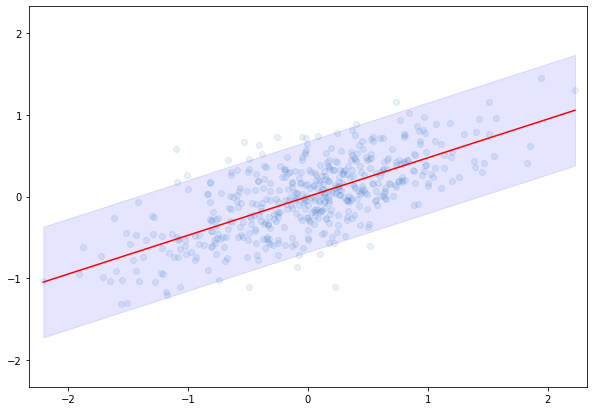

In [4]:

v2 = K[1,1] - K[0,1]**2/K[0,0]
s2 = np.sqrt(v2)
ci = 2*s2

f1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
m2 = f1*K[0,1]/K[0,0]

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(np.array(X[:,0]), np.array(X[:,1]), alpha=.1)
ax.plot(f1, m2, color='red')
ax.fill_between(f1, (m2-ci), (m2+ci), color='b', alpha=.1)

lim = np.max(np.abs(X))+.1
plt.xlim(-lim,lim)
_ = plt.ylim(-lim,lim)
#plt.savefig('gauss2.pdf')


Next, we draw samples from the Gaussian process prior and the posterior, using 
the expressions derived in class. (This code is modified from the code to generate 
the figures in PML 17.2.)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import cholesky
from scipy.spatial.distance import cdist
from IPython.display import clear_output
from time import sleep

def gaussSample(mu, sigma, n):
    A = cholesky(sigma)
    Z = np.random.normal(loc=0, scale=1, size=(len(mu), n))
    return np.dot(A, Z).T + mu

def mu_fun(x):
    return np.zeros_like(np.ravel(x))

def kfn(x, z):
    L = 1
    return 1*np.exp(-(cdist(x/L, z/L)**2)/2)

Draw samples from the prior.

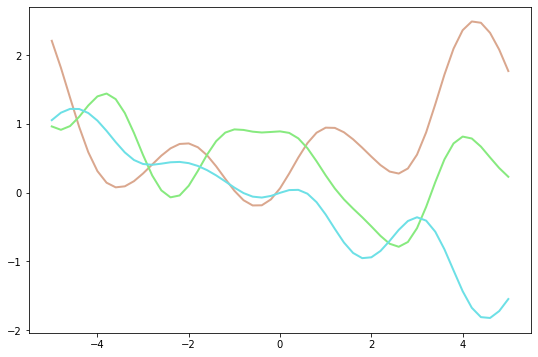

In [6]:
np.random.seed(10)
L = 1
xs = np.arange(-5, 5.2, 0.2)[..., np.newaxis]
ns = len(xs)
keps = 1e-8

for t in np.arange(10):
    clear_output(wait=True)
    plt.figure(figsize=(9, 6))
    # plot sampled functions from the prior
    for i in range(3):
        mu = mu_fun(xs)
        sigma = kfn(xs, xs) + 1e-15 * np.eye(len(xs))
        fs = gaussSample(mu, sigma, 1)
        rgb = np.random.rand(3,)
        plt.plot(np.ravel(xs), np.ravel(fs), color=rgb, linestyle='-', linewidth=2)
    #plt.savefig('prior1.pdf')
    plt.show()
    sleep(.5)


Next, draw samples from the posterior, showing a confidence band for the predicted values. 


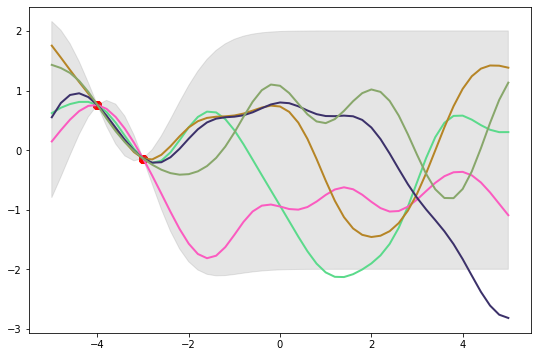

In [7]:
# generate noise-less training data
Xtrain = np.array([[-4], [-3], [-2], [-1], [1]])
Xtrain = np.array([[-4], [-3], [0], [4]])
Xtrain = np.array([[-4], [-3]])
ftrain = np.sin(Xtrain)

K = kfn(Xtrain, Xtrain)
Ks = kfn(Xtrain, xs)
keps = 1e-8
Kss = kfn(xs, xs) + keps * np.eye(len(xs))
Ki = np.linalg.inv(K + keps * np.eye(len(Xtrain)))
postMu = mu_fun(xs)[..., np.newaxis] + np.dot(Ks.T, np.dot(Ki, (ftrain - mu_fun(Xtrain)[..., np.newaxis])))
postCov = Kss - np.dot(Ks.T, np.dot(Ki, Ks))


for t in np.arange(50):
    clear_output(wait=True)
    fig, ax2 = plt.subplots(1, 1, figsize=(9, 6))

    mu = np.ravel(postMu)
    S2 = np.diag(postCov)
    f = np.concatenate([mu + 2 * np.sqrt(S2), np.flip(mu - 2 * np.sqrt(S2), axis=0)])
    ax2.fill(np.concatenate([xs, np.flip(xs, axis=0)]), f, color='gray', alpha=0.2)

    for i in range(5):
        mu = np.ravel(postMu)
        sigma = postCov
        fs = gaussSample(mu, sigma, 1)
        rgb = np.random.rand(3,)
        ax2.plot(np.ravel(xs), np.ravel(fs), c=rgb, linestyle='-', linewidth=2)
        ax2.scatter(Xtrain, ftrain, color='red', marker='o', linewidth=3)
    sleep(.2)
    #plt.savefig('posterior1.pdf')
    plt.show()
    


In this next example, we apply Gaussian process regression to the gold medal 
times for the men's and women's marathon races in the Olympics.


In [8]:
import pandas as pd
dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/gaussian_processes/olympic_results.csv')
events = set(np.array(dat['Event']))
events

{'10000M Men',
 '10000M Women',
 '100M Hurdles Women',
 '100M Men',
 '100M Women',
 '110M Hurdles Men',
 '1500M Men',
 '1500M Women',
 '200M Men',
 '200M Women',
 '20Km Race Walk Men',
 '20Km Race Walk Women',
 '3000M Steeplechase Men',
 '3000M Steeplechase Women',
 '400M Hurdles Men',
 '400M Hurdles Women',
 '400M Men',
 '400M Women',
 '4X100M Relay Men',
 '4X100M Relay Women',
 '4X400M Relay Men',
 '4X400M Relay Women',
 '5000M Men',
 '5000M Women',
 '50Km Race Walk Men',
 '800M Men',
 '800M Women',
 'Decathlon Men',
 'Discus Throw Men',
 'Discus Throw Women',
 'Hammer Throw Men',
 'Hammer Throw Women',
 'Heptathlon Women',
 'High Jump Men',
 'High Jump Women',
 'Javelin Throw Men',
 'Javelin Throw Women',
 'Long Jump Men',
 'Long Jump Women',
 'Marathon Men',
 'Marathon Women',
 'Pole Vault Men',
 'Pole Vault Women',
 'Shot Put Men',
 'Shot Put Women',
 'Triple Jump Men',
 'Triple Jump Women'}

In [9]:
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
year = np.array(marathon['Year'])
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)
    
marathon['Minutes per Mile'] = mpm
marathon

,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
1456,M,Marathon Men,Athens,1896,G,Spyridon LOUIS,GRE,2:58:50,6.825700
1414,M,Marathon Men,Paris,1900,G,Michel THÃATO,FRA,2:59:45.0,6.860687
1453,M,Marathon Men,St Louis,1904,G,Thomas HICKS,USA,3:28:53.0,7.972646
1411,M,Marathon Men,London,1908,G,John HAYES,USA,2:55:18.4,6.691094
1450,M,Marathon Men,Stockholm,1912,G,Kennedy Kane MCARTHUR,RSA,2:36:54.8,5.989059
1408,M,Marathon Men,Antwerp,1920,G,Hannes KOLEHMAINEN,FIN,2:32:35.8,5.824300
1447,M,Marathon Men,Paris,1924,G,Albin STENROOS,FIN,2:41:22.6,6.159415
1405,M,Marathon Men,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32:57,5.837786
1444,M,Marathon Men,Los Angeles,1932,G,Juan Carlos ZABALA,ARG,2:31:36,5.786260
1402,M,Marathon Men,Berlin,1936,G,Kitei SON,JPN,2:29:19.2,5.699237


In [10]:
def mu2_fun(x):
    return np.zeros_like(np.ravel(x)) + 5

def k2fn(x, z):
    L = 6
    return (1/L)*np.exp(-(cdist(x/L, z/L)**2)/2)

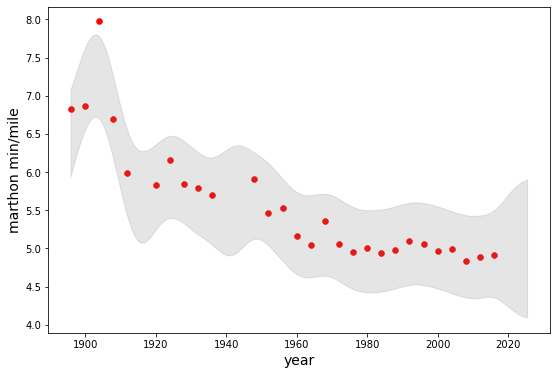

In [11]:
Xtrain = year[..., np.newaxis]
ftrain = np.array(mpm)[..., np.newaxis]
K = k2fn(Xtrain, Xtrain)
xs = np.arange(min(year), max(year)+10, 0.5)[..., np.newaxis]

K = k2fn(Xtrain, Xtrain)
Ks = k2fn(Xtrain, xs)
sigma2 = .05
Kss = k2fn(xs, xs) + sigma2 * np.eye(len(xs))
Ki = np.linalg.inv(K + sigma2 * np.eye(len(Xtrain)))
postMu = mu2_fun(xs)[..., np.newaxis] + np.dot(Ks.T, np.dot(Ki, (ftrain - mu2_fun(Xtrain)[..., np.newaxis])))
postCov = Kss - np.dot(Ks.T, np.dot(Ki, Ks))

fig, ax2 = plt.subplots(1, 1, figsize=(9, 6))
mu = np.ravel(postMu)
S2 = np.diag(postCov)
f = np.concatenate([mu + 2*np.sqrt(S2), np.flip(mu - 2*np.sqrt(S2), axis=0)])
ax2.fill(np.concatenate([xs, np.flip(xs, axis=0)]), f, color='gray', alpha=0.2)


mu = np.ravel(postMu)
sigma = postCov
fs = gaussSample(mu, sigma, 1)
#ax2.plot(np.ravel(xs), np.ravel(fs), c='r', linestyle='-', linewidth=2)
ax2.scatter(Xtrain, ftrain, color='red', marker='o', linewidth=.5)
ax2.set_xlabel('year', fontsize=14)
_ = ax2.set_ylabel('marthon min/mile', fontsize=14)
plt.savefig('marathon.pdf')

In [12]:
def mu2_fun(x):
    return np.zeros_like(np.ravel(x)) + 5

def k2fn(x, z):
    L = 6
    return (1/L)*np.exp(-(cdist(x/L, z/L)**2)/2)

In [13]:
dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/gaussian_processes/olympic_results.csv')
set(np.array(dat['Event']))
wmarathon = dat[dat['Event'] == 'Marathon Women']
wmarathon = wmarathon[wmarathon['Medal']=='G']
wmarathon = wmarathon.sort_values('Year')
year = np.array(wmarathon['Year'])
time = np.array(wmarathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)
    
wmarathon['Minutes per Mile'] = mpm
wmarathon

,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
2307,W,Marathon Women,Los Angeles,1984,G,Joan BENOIT,USA,2:24:52,5.529262
2319,W,Marathon Women,Seoul,1988,G,Rosa MOTA,POR,2:25:40,5.559796
2304,W,Marathon Women,Barcelona,1992,G,Valentina YEGOROVA,EUN,2:32:41,5.827608
2316,W,Marathon Women,Atlanta,1996,G,Fatuma ROBA,ETH,2:26:05,5.575700
2301,W,Marathon Women,Sydney,2000,G,Naoko TAKAHASHI,JPN,02:23:14,5.466921
2313,W,Marathon Women,Athens,2004,G,Mizuki NOGUCHI,JPN,2:26:20,5.585242
2298,W,Marathon Women,Beijing,2008,G,Constantina TOMESCU,ROU,2:26:44,5.600509
2310,W,Marathon Women,London,2012,G,Tiki GELANA,ETH,2:23:07,5.462468
2295,W,Marathon Women,Rio,2016,G,Jemima Jelagat SUMGONG,KEN,2:24:04,5.498728


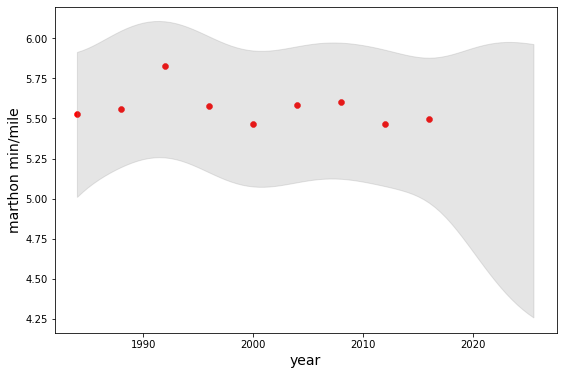

In [14]:
Xtrain = year[..., np.newaxis]
ftrain = np.array(mpm)[..., np.newaxis]
K = k2fn(Xtrain, Xtrain)
xs = np.arange(min(year), max(year)+10, 0.5)[..., np.newaxis]

K = k2fn(Xtrain, Xtrain)
Ks = k2fn(Xtrain, xs)
sigma2 = .03
Kss = k2fn(xs, xs) + sigma2 * np.eye(len(xs))
Ki = np.linalg.inv(K + sigma2 * np.eye(len(Xtrain)))
postMu = mu2_fun(xs)[..., np.newaxis] + np.dot(Ks.T, np.dot(Ki, (ftrain - mu2_fun(Xtrain)[..., np.newaxis])))
postCov = Kss - np.dot(Ks.T, np.dot(Ki, Ks))

fig, ax2 = plt.subplots(1, 1, figsize=(9, 6))
mu = np.ravel(postMu)
S2 = np.diag(postCov)
f = np.concatenate([mu + 2*np.sqrt(S2), np.flip(mu - 2*np.sqrt(S2), axis=0)])
ax2.fill(np.concatenate([xs, np.flip(xs, axis=0)]), f, color='gray', alpha=0.2)


mu = np.ravel(postMu)
sigma = postCov
fs = gaussSample(mu, sigma, 1)
#ax2.plot(np.ravel(xs), np.ravel(fs), c='r', linestyle='-', linewidth=2)
ax2.scatter(Xtrain, ftrain, color='red', marker='o', linewidth=.5)
ax2.set_xlabel('year', fontsize=14)
_ = ax2.set_ylabel('marthon min/mile', fontsize=14)
plt.savefig('wmarathon.pdf')